In [2]:
%load_ext autoreload

%autoreload 2

In [4]:
from glob import glob
import os
import pickle

import scipy.linalg
import matplotlib.pyplot as plt

import emcee

import kepler
import threebody

import minuit_wrap
%matplotlib inline

In [5]:
import logging
logger = logging.getLogger()

#logger.setLevel(logging.DEBUG)
fh = logging.FileHandler("fitting.log")
formatter = logging.Formatter('%(asctime)s - %(module)s:%(funcName)s:%(lineno)s - %(message)s')
fh.setFormatter(formatter)
logger.addHandler(fh)


In [6]:
# numpy binds itself to one CPU; unbind it
#import os
#os.system("taskset -p 0xff %d" % os.getpid());

In [7]:
#import matplotlib
#matplotlib.rcParams['savefig.dpi'] = 120

In [301]:
#F = threebody.Fitter("0337+17-scott-2013-06-06",tzrmjd_middle='weighted',priors=['dbeta','dgamma'],ppn_mode='heavysimple')
#F = threebody.Fitter("0337+17-scott-2013-06-06",
#    tzrmjd_middle='weighted',priors=['dbeta','dgamma'],
#    use_quad=True,tol=1e-20,ppn_mode='heavysimple')
#F = threebody.Fitter("0337+17-scott-2013-06-06",tzrmjd_middle='weighted',
#    only_tels=['AO1440','AO1350','GBT1500'],
#    ppn_mode='heavysimple')
#F = threebody.Fitter("0337+17-scott-2013-06-06",tzrmjd_middle='weighted',
#    only_tels=['WSRT1400'],
#    ppn_mode='heavysimple')
#F = threebody.Fitter(files="0337+17-scott-2013-08-29",tzrmjd_middle='weighted',
#                     parfile="0337_tempo2_nobinary.par",
#                     fit_pos=True,
#                     ppn_mode='GR')
#F = threebody.Fitter(files="0337+17-scott-2013-08-29",tzrmjd_middle='auto',
#                     parfile="0337_modified.par",
#                     fit_pos=True,
#                     fit_pm=True,
#                     fit_px=True,
#                     t2_astrometry=True,
#                     ppn_mode='GR')
#F = threebody.Fitter(files="0337+17-scott-2013-08-29",tzrmjd_middle='auto',
#                     parfile="0337_modified.par",
#                     fit_pos=True,
#                     fit_pm=True,
#                     fit_px=True,
#                     t2_astrometry=True,
#                     kopeikin=True,
#                     ppn_mode='heavysimple')
if False:
    fitter_params = dict(files="0337+17-scott-2013-08-29",tzrmjd_middle='auto',
                     parfile="0337_tempo2_pm.par",
                     fit_pos=True,
                     fit_pm=False,
                     fit_px=True,
                     t2_astrometry=True,
                     kopeikin=True,
                     priors=('dbeta','dgamma'),
                     ppn_mode='heavysimple')
elif False:
    fitter_params = dict(files="0337+17-scott-2013-08-29",tzrmjd_middle='auto',
                     parfile="0337_tempo2_pm.par",
                     fit_pos=True,
                     fit_pm=False,
                     fit_px=True,
                     t2_astrometry=True,
                     kopeikin=True,
                     shapiro=False,
                     priors=('dbeta','dgamma'),
                     ppn_mode='heavysimple')
elif False:
    fitter_params = dict(files="0337+17-scott-2013-08-29",tzrmjd_middle='auto',
                     parfile="0337_tempo2_pm.par",
                     fit_pos=True,
                     fit_pm=False,
                     fit_px=True,
                     t2_astrometry=True,
                     kopeikin=True,
                     general=False,
                     priors=('dbeta','dgamma'),
                     ppn_mode='heavysimple')
elif False:
    fitter_params = dict(files="0337+17-scott-2013-08-29",tzrmjd_middle='auto',
                     parfile="0337_tempo2_pm.par",
                     fit_pos=True,
                     fit_pm=False,
                     fit_px=True,
                     t2_astrometry=True,
                     kopeikin=True,
                     ppn_mode=None)
elif False:
    fitter_params = dict(files="0337+17-scott-2013-08-29",tzrmjd_middle='auto',
                     parfile="0337_tempo2_px.par",
                     fit_pos=True,
                     fit_pm=False,
                     fit_px=True,
                     t2_astrometry=True,
                     kopeikin=True,
                     ppn_mode='GR')
elif False:
    fitter_params = dict(files="0337+17-scott-2013-08-29",tzrmjd_middle='auto',
                     parfile="0337_tempo2_pm.par",
                     fit_pos=True,
                     fit_pm=False,
                     fit_px=True,
                     t2_astrometry=True,
                     kopeikin=True,
                     ppn_mode='GR')
elif False:
    fitter_params = dict(files="0337+17-scott-2014-01-22",
                     tzrmjd_middle='auto',
                     parfile="0337_tempo2_px_optical.par",
                     fit_pos=True,
                     fit_pm=False,
                     fit_px=False,
                     t2_astrometry=True,
                     kopeikin=True,
                     ppn_mode='GR')
elif False:
    fitter_params = dict(files="0337+17-scott-2014-01-22",
                     tzrmjd_middle='auto',
                     parfile="0337_tempo2_px_optical.par",
                     fit_pos=True,
                     fit_pm=False,
                     fit_px=False,
                     t2_astrometry=True,
                     kopeikin=False,
                     ppn_mode='GR')
elif False:
    fitter_params = dict(files="0337+17-scott-2014-01-22",
                     tzrmjd_middle='auto',
                     parfile="0337_tempo2_px_optical.par",
                     fit_pos=True,
                     fit_pm=False,
                     fit_px=False,
                     t2_astrometry=True,
                     kopeikin=False,
                     priors=('dbeta','dgamma'),
                     ppn_mode='heavysimple')
elif False:
    fitter_params = dict(files="0337+17-anne-2014-01-28",
                     tzrmjd_middle='auto',
                     parfile="0337_tempo2_px_optical.par",
                     fit_pos=True,
                     fit_pm=False,
                     fit_px=False,
                     t2_astrometry=True,
                     kopeikin=False,
                     priors=('dbeta','dgamma'),
                     ppn_mode='heavysimple')
elif False:
    fitter_params = dict(files="0337+17-anne-2014-02-04c",
                     tzrmjd_middle='auto',
                     parfile="0337_tempo2_px_optical.par",
                     fit_pos=True,
                     fit_pm=False,
                     fit_px=False,
                     t2_astrometry=True,
                     kopeikin=False,
                     ppn_mode='GR')
elif False:
    fitter_params = dict(files="0337+17-anne-2014-02-04c",
                     tzrmjd_middle='auto',
                     parfile="0337_tempo_px_optical.par",
                     fit_pos=False,
                     fit_pm=False,
                     fit_px=False,
                     t2_astrometry=True,
                     kopeikin=False,
                     ppn_mode='GR')
elif False:
    fitter_params = dict(files="0337+17-anne-2014-09-22",
                     tzrmjd_middle='auto',
                     parfile="0337_tempo_px_optical.par",
                     fit_pos=True,
                     fit_pm=False,
                     fit_px=False,
                     t2_astrometry=True,
                     kopeikin=False,
                     ppn_mode='GR')
elif False:
    fitter_params = dict(files="0337+17-anne-2014-09-22",
                     tzrmjd_middle='auto',
                     parfile="0337_tempo2_px_optical.par",
                     fit_pos=True,
                     fit_pm=False,
                     fit_px=False,
                     t2_astrometry=True,
                     kopeikin=False,
                     priors=('dbeta','dgamma'),
                     ppn_mode='heavysimple')
elif False:
    fitter_params = dict(files="0337+17-anne-2014-09-29",
                     tzrmjd_middle='auto',
                     parfile="0337_tempo2_px_optical.par",
                     fit_pos=True,
                     fit_pm=False,
                     fit_px=False,
                     t2_astrometry=True,
                     kopeikin=False,
                     priors=('dbeta','dgamma'),
                     ppn_mode='heavysimple')
elif False:
    fitter_params = dict(files="0337+17-anne-2014-09-22",
                     tzrmjd_middle='auto',
                     parfile="0337_tempo2_px_optical.par",
                     fit_pos=True,
                     fit_pm=False,
                     fit_px=False,
                     t2_astrometry=True,
                     kopeikin=False,
                     only_tels=('GBT1500','WSRT1400'),
                     priors=('dbeta','dgamma'),
                     ppn_mode='heavysimple')
elif False:
    fitter_params = dict(files="0337+17-anne-2014-09-22",
                     tzrmjd_middle='auto',
                     parfile="0337_tempo2_px_optical.par",
                     fit_pos=True,
                     fit_pm=False,
                     fit_px=False,
                     t2_astrometry=True,
                     efac=(('AO1440',1.45),
                           ('GBT1500',1.11),
                           ('WSRT1400',1.45)),
                     kopeikin=False,
                     priors=('dbeta','dgamma'),
                     ppn_mode='heavysimple')
elif False:
    fitter_params = dict(files="0337_6vec_table_150131_pulses.fits",
                     tzrmjd_middle='auto',
                     fit_pos=False,
                     fit_pm=False,
                     fit_px=False,
                     t2_astrometry=False,
                     efac=(('AO1440',1.45),
                           ('GBT1500',1.11),
                           ('GBT1500s',1.11),
                           ('WSRT1400',1.45)),
                     kopeikin=False,
                     priors=('dbeta','dgamma'),
                     linear_jumps=True,
                     ppn_mode='heavysimple')
elif False:
    fitter_params = dict(files="0337+17-anne-2014-09-22",
                     tzrmjd_middle='auto',
                     parfile="0337_tempo2_px_optical.par",
                     fit_pos=True,
                     fit_pm=True,
                     fit_px=True,
                     t2_astrometry=True,
                     efac=(('AO1440',1.45),
                           ('GBT1500',1.11),
                           ('WSRT1400',1.45)),
                     kopeikin=False,
                     priors=('dbeta','dgamma'),
                     ppn_mode='heavysimple')
elif False:
    fitter_params = dict(files="0337+17-anne-2014-09-22",
                     tzrmjd_middle='auto',
                     parfile="0337_tempo2_px_optical.par",
                     fit_pos=True,
                     fit_pm=True,
                     fit_px=True,
                     t2_astrometry=True,
                     efac=(('AO1440',1.45),
                           ('GBT1500',1.11),
                           ('WSRT1400',1.45)),
                     kopeikin=False,
                     priors=('dbeta','dgamma'),
                     ppn_mode='heavysimple')
elif False:
    fitter_params = dict(files="tuned_mueller_pulses_selected",
                     tzrmjd_middle='auto',
                     parfile="0337_tempo2_px_optical.par",
                     fit_pos=True,
                     fit_pm=True,
                     fit_px=True,
                     t2_astrometry=True,
                     efac=(('AO1440',1.0),
                           ('GBT1500',1.0),
                           ('WSRT1400',1.0)),
                     kopeikin=False,
                     priors=('dbeta','dgamma'),
                     ppn_mode='heavysimple',
                     toa_mode="pipeline")
elif False:
    fitter_params = dict(files="tuned_mueller_pulses_selected",
                     tzrmjd_middle='auto',
                     parfile="0337_tempo2_px_optical.par",
                     fit_pos=True,
                     fit_pm=True,
                     fit_px=True,
                     t2_astrometry=True,
                     efac=(('AO1440',1.0),
                           ('GBT1500',1.0),
                           ('WSRT1400',1.0)),
                     kopeikin=False,
                     ppn_mode='GR',
                     linear_jumps=True,
                     linear_dm=True,
                     toa_mode="pipeline")
elif True:
    fitter_params = dict(files="tuned_mueller_pulses_selected",
                     tzrmjd_middle='auto',
                     parfile="0337_tempo2_px_optical.par",
                     fit_pos=True,
                     fit_pm=True,
                     fit_px=True,
                     t2_astrometry=True,
                     efac=(('AO1440',1.0),
                           ('GBT1500',1.0),
                           ('WSRT1400',1.0)),
                     kopeikin=False,
                     ppn_mode='heavysimple',
                     linear_jumps=True,
                     linear_dm=True,
                     toa_mode="pipeline")
else:
    runid = "7983"
    fitter_params = pickle.load(open("emcee-chains/%s.nimrod/fitter_params.pickle" % runid))
#F = threebody.Fitter("0337+17-scott-2013-06-06",tzrmjd_middle='weighted',ppn_mode='GR')
#F = threebody.Fitter("0337+17-scott-2013-06-06",tzrmjd_middle='weighted',general=False,ppn_mode='GR')
#F = threebody.Fitter("0337+17-scott-2013-06-06",tzrmjd_middle=True)
with open("fitter_params.pickle","wb") as f:
    pickle.dump(fitter_params,f)
F = threebody.Fitter(**fitter_params)

In [302]:
F.tel_list, len(F.mjds)

(['AO_1400', 'AO_430', 'GBT_1400', 'WSRT_1400', 'WSRT_350'], 24301)

In [303]:
print F.parameters
print len(F.parameters)

['asini_i', 'pb_i', 'eps1_i', 'eps2_i', 'tasc_i', 'acosi_i', 'q_i', 'asini_o', 'pb_o', 'eps1_o', 'eps2_o', 'tasc_o', 'acosi_o', 'delta_lan', 'delta', 'dgamma', 'dbeta']
17


In [304]:
F.best_parameters

{'acosi_i': 1.4917553649083741,
 'acosi_o': 91.53728918325116,
 'asini_i': 1.2175267843858402,
 'asini_o': 74.67270166579456,
 'd_DECJ': -1.070731501745044e-09,
 'd_PMDEC': -1.9580532733266362e-10,
 'd_PMRA': 9.885280864586482e-11,
 'd_PX': -0.5531255775641357,
 'd_RAJ': -3.4254785902426147e-09,
 'dbeta': 0,
 'delta': 0,
 'delta_lan': -1.1875825731197669e-05,
 'dgamma': 0,
 'eps1_i': 0.0006871812134080429,
 'eps1_o': 0.0351862386078509,
 'eps2_i': -9.115741533177484e-05,
 'eps2_o': -0.003462197684711702,
 'f0': 365.95336311128915,
 'j_AO1350': 5.416890691232084e-05,
 'j_AO1440': 4.8927007422127645e-05,
 'j_AO327': 6.509749509896134e-05,
 'j_GBT1500': 6.2342354290442e-05,
 'j_GBT350': 1.8517017863581812e-05,
 'j_GBT820': 6.785312385988059e-05,
 'j_NCY1400': 0.000675,
 'j_WSRT350': -3.659850586544055e-05,
 'pb_i': 1.6293969535220398,
 'pb_o': 327.25748562198874,
 'ppn_mode': 'heavysimple',
 'q_i': 0.13726698219882472,
 'shapiro': True,
 'tasc_i': 0.40771702695152506,
 'tasc_o': 313.93575

In [305]:
if 'j_NCY1400' not in F.best_errors:
    F.best_errors['j_NCY1400'] = F.best_errors['j_GBT1500']
if 'j_GBT1500s' not in F.best_parameters:
    F.best_parameters['j_GBT1500s'] = F.best_parameters['j_GBT1500']
if 'j_GBT1500s' not in F.best_errors:
    F.best_errors['j_GBT1500s'] = F.best_errors['j_GBT1500']
if 'j_AO430' not in F.best_parameters:
    F.best_parameters['j_AO430'] = 0
if 'j_AO430' not in F.best_errors:
    F.best_errors['j_AO430'] = F.best_errors['j_GBT1500']
if 'j_WSRT350' not in F.best_parameters:
    F.best_parameters['j_WSRT350'] = 0
if 'j_WSRT350' not in F.best_errors:
    F.best_errors['j_WSRT350'] = F.best_errors['j_GBT1500']
 

In [306]:
#for n in threebody.astro_names:
#    F.best_parameters[n] = 0

In [307]:
#F.best_parameters['d_PX'] = 0
#F.best_parameters['pm_x'] = 0
#F.best_parameters['pm_y'] = 0


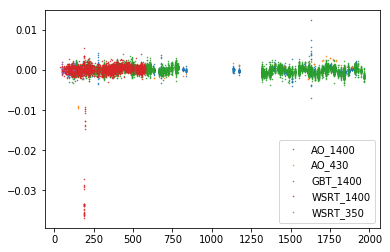

In [308]:
rload = F.residuals(F.best_parameters)
for ti, t in enumerate(F.tel_list):
    c = F.tels == ti
    plt.plot(F.mjds[c], rload[c], 
             ".", markersize=1, label=t)
plt.legend(loc="best")
plt.show()

In [309]:
F.goodness_of_fit(F.best_parameters)

175940.85862614470221

In [310]:
mfun = F.make_mfun()

In [311]:
mfun(*[F.best_parameters[p] for p in F.parameters])

175940.85862614470221

In [318]:
M = minuit_wrap.Fitter(F.make_mfun())

In [319]:
for p in F.parameters:
    M.values[p] = F.best_parameters[p]
    M.errors[p] = F.best_errors[p]
M.set_normalization()

In [320]:
if False:
    for p in F.parameters:
        if not p.startswith("j_"):
            M.fixed[p] = True


In [321]:
#if F.linear_jumps:
#    print "linear jumps"
#    for p in F.parameters:
#        if p.startswith("j_"):
#            M.fixed[p] = True


In [322]:
if False:
    for p in F.parameters:
        M.fixed[p] = False

In [323]:
M.best_filename = "fitter_best_values.pickle"
M.tol = 100
#M.eps = 1e-6
M.strategy = 1
M.printMode = 3
M.migrad()

FCN = 151134.380179 
 TOTAL NCALL = 2223 
 NCALLS = 2223 
 
 
 EDM = 32.6844768644 
 GOAL EDM = 0.01 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,asini_i,-24.4954,1.54996,0,0,,,
2,pb_i,5.04554,0.0587023,0,0,,,
3,eps1_i,-7.89949,0.376254,0,0,,,
4,eps2_i,-8.79097,0.512365,0,0,,,
5,tasc_i,-14.5265,0.143338,0,0,,,
6,acosi_i,5798.49,7.71909,0,0,,,
7,q_i,3701.05,0.426212,0,0,,,
8,asini_o,25.7455,0.609894,0,0,,,
9,pb_o,332.74,0.184638,0,0,,,
10,eps1_o,-0.093822,1.17226,0,0,,,


({'hesse_failed': False, 'has_reached_call_limit': False, 'has_accurate_covar': False, 'has_posdef_covar': False, 'up': 1.0, 'edm': 32.68447686436626, 'is_valid': False, 'is_above_max_edm': True, 'has_covariance': True, 'has_made_posdef_covar': True, 'has_valid_parameters': True, 'fval': 151134.3801792917, 'nfcn': 2223},
 [{'is_const': False, 'name': 'asini_i', 'has_limits': False, 'value': -24.495448297798415, 'number': 0, 'has_lower_limit': False, 'upper_limit': 0.0, 'lower_limit': 0.0, 'has_upper_limit': False, 'error': 1.5499574249537338, 'is_fixed': False},
  {'is_const': False, 'name': 'pb_i', 'has_limits': False, 'value': 5.045544193549022, 'number': 1, 'has_lower_limit': False, 'upper_limit': 0.0, 'lower_limit': 0.0, 'has_upper_limit': False, 'error': 0.05870230588129517, 'is_fixed': False},
  {'is_const': False, 'name': 'eps1_i', 'has_limits': False, 'value': -7.8994881021597445, 'number': 2, 'has_lower_limit': False, 'upper_limit': 0.0, 'lower_limit': 0.0, 'has_upper_limit': 

In [37]:
M.tol = 100
#M.eps = 1e-6
M.strategy = 1
M.printMode = 3
M.simplex()

AttributeError: 'iminuit._libiminuit.Minuit' object has no attribute 'printMode'

In [ ]:
for (i,p) in enumerate(F.parameters):
    M.values[p] = M.best_values[p]
    M.errors[p] = F.best_errors[p]
M.set_normalization() 

In [ ]:
best_so_far = np.load("emcee-chains/1045.nimrod/best_so_far.npy")
for (i,p) in enumerate(F.parameters):
    M.values[p] = best_so_far[i]
    M.errors[p] = F.best_errors[p]
M.set_normalization()    

In [ ]:
M.tol = 100
M.eps = 1e-6
M.strategy = 1
M.printMode = 3
M.migrad()

In [ ]:
for p in F.parameters:
    print p, (M.best_values[p]-F.best_parameters[p])/F.best_errors[p]

In [ ]:
M.best_values

In [ ]:
mfun(*[M.best_values[p] for p in F.parameters])

In [ ]:
if False:
    import cPickle as pickle
    with open(M.best_filename,"wb") as f:
        pickle.dump(M.best_values, f)

In [ ]:
M._minuit.errors

In [ ]:
new_walkers = np.load("emcee-chains/845.nimrod/new_walkers.npy")
new_walkers = new_walkers.reshape((-1,new_walkers.shape[-1]))
new_walkers -= np.mean(new_walkers,axis=0)
delta = new_walkers[np.random.randint(new_walkers.shape[0])]
for (i,p) in enumerate(F.parameters):
    M.values[p] = M.best_values[p] + delta[i]
    M.errors[p] = F.best_errors[p]
M.set_normalization() 